# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Include transformations and interactions, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
6. Summarize your results from 1 to 5. Have you learned anything about overfitting and underfitting, or model selection?
7. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.



<Axes: >

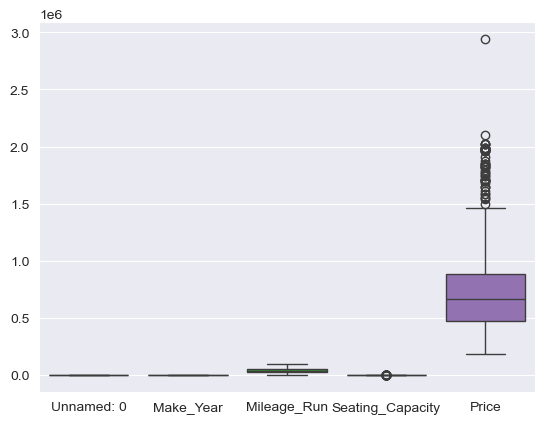

In [15]:
#1 cleaning the data and visualizations
import pandas as pd
import numpy as np
import seaborn as sns

df = pd.read_csv('cars_hw.csv')
df0 = df # Save the original data for a few plots
sns.boxplot(data=df)

<Axes: >

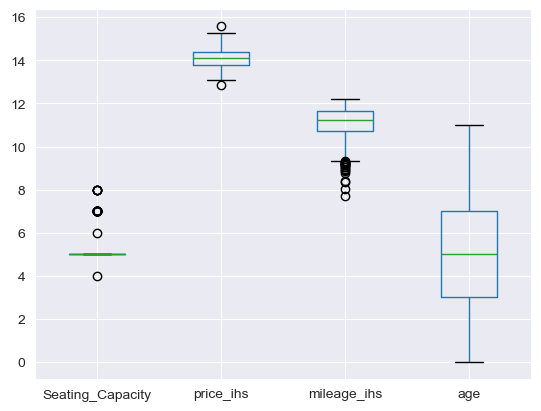

In [16]:
df['price_ihs'] = np.arcsinh(df['Price'])
df['mileage_ihs'] = np.arcsinh(df['Mileage_Run'])
df['age'] = max(df['Make_Year'])-df['Make_Year']
df = df.drop(['Price','Mileage_Run','Make_Year','Unnamed: 0'],axis=1)
df.boxplot()

In [17]:
#2 removing categorical variables/encoding:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Define categorical features
categorical_features = ['Make', 'Color', 'Body_Type', 'Fuel_Type', 'Transmission', 'Transmission_Type']

# One-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ],
    remainder='passthrough'
)

In [19]:
N = df.shape[0]
df = df.sample(frac=1, random_state=100) # randomize the order in which data appears
train_size = int(.8*N)

# How to do the split as needed:
df_train = df[0:train_size]
y_train = df_train['price_ihs']

df_test = df[train_size:]
y_test = df_test['price_ihs']

In [20]:
from sklearn import linear_model

# Numeric regression:
var_n = ['age','mileage_ihs','Seating_Capacity'] # Select variables
X_train_n = df_train.loc[:,var_n] # Process training covariates
reg_n = linear_model.LinearRegression().fit(X_train_n,y_train) # Run regression
X_test_n = df_test.loc[:,var_n] # Process test covariates
y_hat = reg_n.predict(X_test_n)
print('Numeric only Rsq: ', reg_n.score(X_test_n,y_test)) # R2
rmse_n = np.sqrt( np.mean( (y_test - y_hat)**2 ))
print('Numeric only RMSE: ', rmse_n) # R2

Numeric only Rsq:  0.4750029165676344
Numeric only RMSE:  0.31530652630313183


In [21]:
# Categorical regression:
var_cat = ['Make','Body_Type','Color','Fuel_Type','Transmission','Transmission_Type']
#
# Use a loop to make the dummy dataframe, but you could do it by hand in a bunch of lines:
dummies = pd.DataFrame([]) # In general, use lists and append instead of DataFrame and pd.concat
for var in var_cat: 
    new_dummies = pd.get_dummies( df.loc[:,var], drop_first=True, dtype=int)
    dummies = pd.concat([dummies, new_dummies], axis=1, ignore_index=True) 
    X_train_c = dummies.iloc[0:train_size,:]
    X_test_c = dummies.iloc[train_size:,:]
#
reg_c = linear_model.LinearRegression().fit(X_train_c,y_train) # Run regression
y_hat_c = reg_c.predict(X_test_c)
print('Categorical only Rsq: ', reg_c.score(X_test_c,y_test)) # R2
rmse_c = np.sqrt( np.mean( (y_test - y_hat_c)**2 ))
print('Categorical only RMSE: ', rmse_c) # R2

Categorical only Rsq:  0.6328712991859706
Categorical only RMSE:  0.26367179960539355


In [22]:
# Combine numeric _n and categorical _c variables:
X_train_all = pd.concat([X_train_n, X_train_c],axis=1, ignore_index=True)
X_test_all = pd.concat([X_test_n, X_test_c],axis=1, ignore_index=True)
#
reg_all = linear_model.LinearRegression().fit(X_train_all,y_train) # Run regression
y_hat_all = reg_all.predict(X_test_all)
print('All Rsq: ', reg_all.score(X_test_all,y_test)) # R2
rmse_all = np.sqrt( np.mean( (y_test - y_hat_all)**2 ))
print('All RMSE: ', rmse_all) # R2

All Rsq:  0.802875472188732
All RMSE:  0.19320788554451918


In [23]:
#5 adding polynomial features to make the model more complex
from sklearn.preprocessing import PolynomialFeatures

for d in np.arange(1,5):
    expander = PolynomialFeatures(degree=d,include_bias=False)
    Z = expander.fit_transform(X_test_n)
    names = expander.get_feature_names_out()
    X_test_d = pd.DataFrame(data=Z, columns = names) 
    Z = expander.fit_transform(X_train_n)
    names = expander.get_feature_names_out()
    X_train_d = pd.DataFrame(data=Z, columns = names)
    X_train_d.reset_index(drop=True, inplace=True)
    X_train_c.reset_index(drop=True, inplace=True)
    X_train_all = pd.concat([X_train_d, X_train_c], axis=1, ignore_index=True)
    #
    # Reset indices for concatenating:
    X_test_d.reset_index(drop=True, inplace=True)
    X_test_c.reset_index(drop=True, inplace=True)
    X_test_all = pd.concat([X_test_d, X_test_c], axis=1, ignore_index=True)
    #
    # Regression metrics:
    reg_all = linear_model.LinearRegression().fit(X_train_all,y_train) # Run regression
    print(d, ' Rsq: ', reg_all.score(X_test_all,y_test)) # R2
    y_hat_all = reg_all.predict(X_test_all)
    rmse_all = np.sqrt( np.mean( (y_test - y_hat_all)**2 ))
    print(d, 'RMSE: ', rmse_all) # R2


1  Rsq:  0.802875472188732
1 RMSE:  0.19320788554451918
2  Rsq:  0.7958960342123993
2 RMSE:  0.1965985164320044
3  Rsq:  0.7991066849965203
3 RMSE:  0.19504609387042657
4  Rsq:  -27171097177538.78
4 RMSE:  2268339.7454694593


#6
It seems like more complex models are more prone to overfitting than less complex models are. However, some models that are overly complex seem to underfit. These simple models had moderate performance but higher error rates (RMSE) and lower values, especially on the test set. The performance discrepancy between train and test sets hinted that the model was somewhat underfit. Adding transformations and interaction terms improved the model significantly, as reflected in lower RMSE and higher R^2 scores on both training and test sets. However, some complex models started to show higher performance on the training set relative to the test set, suggesting potential overfitting where the model began to fit the training data’s noise rather than generalizable patterns.

In [24]:
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

lasso_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=0.1, random_state=42))
])

# Fit the model to the training data
lasso_model.fit(X_train_n, y_train)

# Predict on training data
y_train_pred = lasso_model.predict(X_train_n)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

# Predict on test data
y_test_pred = lasso_model.predict(X_train_n)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

# Display the results
print("Lasso Model Performance:")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Training R^2: {train_r2:.2f}")
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test R^2: {test_r2:.2f}")



ValueError: A given column is not a column of the dataframe